Updated: 02/02/2024

This workbook is an extension of quadratic_checks, specifically focussing on reproducing the results of Mitman 2023. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction_tests.spatial_reconstruction import *
from matplotlib.animation import FuncAnimation
from scipy.interpolate import UnivariateSpline
from Visualisation.qnm_vis import * 
from qnmfitsrd.CCE_file_getter import *
import datetime
from scipy.optimize import least_squares

l_max = 7
n_max = 7

In [2]:
CCE_sim1 = CCE_to_sim_simplified(sim_num='0001')
CCE_sim2 = CCE_to_sim_simplified(sim_num='0002')
CCE_sim3 = CCE_to_sim_simplified(sim_num='0003')
CCE_sim4 = CCE_to_sim_simplified(sim_num='0004')
CCE_sim5 = CCE_to_sim_simplified(sim_num='0005')
CCE_sim6 = CCE_to_sim_simplified(sim_num='0006')
CCE_sim7 = CCE_to_sim_simplified(sim_num='0007')
CCE_sim8 = CCE_to_sim_simplified(sim_num='0008')
CCE_sim9 = CCE_to_sim_simplified(sim_num='0009')
CCE_sim10 = CCE_to_sim_simplified(sim_num='0010')
CCE_sim11 = CCE_to_sim_simplified(sim_num='0011')
CCE_sim12 = CCE_to_sim_simplified(sim_num='0012')
CCE_sim13 = CCE_to_sim_simplified(sim_num='0013')

CCE_sim305 = CCE_to_sim_simplified(sim_num='0305')

In [3]:
sim_1502 = qnmfits.SXS(ID=1502, zero_time='norm')
sim_1476 = qnmfits.SXS(ID=1476, zero_time='norm')
sim_1506 = qnmfits.SXS(ID=1506, zero_time='norm')
sim_1508 = qnmfits.SXS(ID=1508, zero_time='norm')
sim_1474 = qnmfits.SXS(ID=1474, zero_time='norm')
sim_1505 = qnmfits.SXS(ID=1505, zero_time='norm')
sim_1504 = qnmfits.SXS(ID=1504, zero_time='norm')
sim_1485 = qnmfits.SXS(ID=1485, zero_time='norm')
sim_1486 = qnmfits.SXS(ID=1486, zero_time='norm')
sim_1441 = qnmfits.SXS(ID=1441, zero_time='norm')
sim_1500 = qnmfits.SXS(ID=1500, zero_time='norm')
sim_1492 = qnmfits.SXS(ID=1492, zero_time='norm')
sim_1465 = qnmfits.SXS(ID=1465, zero_time='norm')
sim_1458 = qnmfits.SXS(ID=1458, zero_time='norm')
sim_1438 = qnmfits.SXS(ID=1438, zero_time='norm')
sim_1430 = qnmfits.SXS(ID=1430, zero_time='norm')

/data/rvnd2/python_envs/python-3.11-clone/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:1502v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1502v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 83.0M/83.0M [00:13<00:00, 6.52MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1476v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1476v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 80.4M/80.4M [00:12<00:00, 6.60MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1506v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1506v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 82.8M/82.8M [00:13<00:00, 6.45MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1508v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1508v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 83.7M/83.7M [00:13<00:00, 6.40MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1474v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1474v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 81.5M/81.5M [00:13<00:00, 6.18MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1505v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1505v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 83.3M/83.3M [00:14<00:00, 6.00MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1504v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1504v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 84.4M/84.4M [00:13<00:00, 6.53MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1485v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1485v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 84.8M/84.8M [00:13<00:00, 6.70MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1486v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1486v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 86.5M/86.5M [00:13<00:00, 6.83MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1441v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1441v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 96.0M/96.0M [00:14<00:00, 6.85MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1500v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1500v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 79.7M/79.7M [00:13<00:00, 6.22MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1492v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1492v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 78.5M/78.5M [00:13<00:00, 6.23MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1465v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1465v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 78.6M/78.6M [00:13<00:00, 6.32MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1458v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1458v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 80.8M/80.8M [00:13<00:00, 6.43MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1438v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1438v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 85.1M/85.1M [00:13<00:00, 6.81MB/s]


Found the following files to load from the SXS catalog:
    SXS:BBH:1430v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1430v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 88.3M/88.3M [00:14<00:00, 6.61MB/s]


In [10]:

###########################################

spherical_mode = (5,4)
quadratic_mode = (2,2,0,1,2,2,0,1)

###########################################

l, m = spherical_mode 
lp, mp, nprime, pp, lpp, mpp, npp, ppp = quadratic_mode  

# Reproducing Fig. 1

Note this doesn't use the CCE waveforms

TODO: A prop to A1*A2 so need to generalise

In [11]:
start_times = np.array([15.0, 20.0, 25.0, 30.0])

#sims = [CCE_sim1, CCE_sim2, CCE_sim3, CCE_sim4, CCE_sim5, CCE_sim6, CCE_sim7, CCE_sim8, CCE_sim9, CCE_sim10, CCE_sim11, CCE_sim12, CCE_sim13]
sims = [sim_1502, sim_1476, sim_1506, sim_1508, sim_1474, sim_1505, sim_1504, sim_1485, sim_1486, sim_1441, sim_1500, sim_1492, sim_1465, 
        sim_1458, sim_1438, sim_1430]

amp_array = np.zeros((5, len(start_times), len(sims)))

model_l2 = [(4,4,n,1) for n in range(2+1)]
model_q = [(4,4,n,1) for n in range(2+1)] + [quadratic_mode]

l2_amp_index = model_l2.index((4,4,0,1))
q_amp_index = model_q.index(quadratic_mode)

model_l1 = [(2,2,n,1) for n in range(1+1)]
l1_amp_index = model_l1.index((2,2,0,1))

for j, t0 in enumerate(start_times):

    for i, s in enumerate(sims):

        decay_time22 = qnmfits.qnm.omega(2,2,0,1, s.chif_mag, Mf=s.Mf).imag
        decay_time44 = qnmfits.qnm.omega(l,m,0,1, s.chif_mag, Mf=s.Mf).imag
        decay_time22q = qnmfits.qnm.omega(lp,mp,nprime,pp, s.chif_mag, Mf=s.Mf).imag + qnmfits.qnm.omega(lpp,mpp,npp,ppp, s.chif_mag, Mf=s.Mf).imag

        # TODO: This changes from intital mass of BH binary to final mass of BH need to add properly to SXS class 
        t0 = t0*s.Mf

        best_fit_l1 = qnmfits.ringdown_fit(
            s.times,
            s.h[2,2],
            model_l1,
            Mf=s.Mf,
            chif=s.chif_mag,
            t0=t0,
        )

        amp_array[0][j][i] = abs(best_fit_l1['C'][l1_amp_index]*np.exp(-decay_time22*t0))

        best_fit_l2 = qnmfits.ringdown_fit(
            s.times,
            s.h[l,m],
            model_l2,
            Mf=s.Mf,
            chif=s.chif_mag,
            t0=t0,
        )

        amp_array[1][j][i] = abs(best_fit_l2['C'][l2_amp_index]*np.exp(-decay_time44*t0))

        best_fit_q = qnmfits.ringdown_fit(
            s.times,
            s.h[l,l],
            model_q,
            Mf=s.Mf,
            chif=s.chif_mag,
            t0=t0,
        )

        amp_array[2][j][i] = abs(best_fit_q['C'][q_amp_index]*np.exp(-decay_time22q*t0))
        
        amp_array[3][j][i] = s.m1 / s.m2

        if 0.6 > s.chif_mag > 0.8:
            amp_array[4][j][i] = 'triangle_up'
        if 0.4 > s.chif_mag > 0.6:
            amp_array[4][j][i] = 'circle'


In [12]:
def quadratic_model_error(a, x, y):
    return a * x**2 - y

coefs = [] 

for j, _ in enumerate(start_times): 

    x_data = amp_array[0][j]
    y_data = amp_array[2][j]
    initial_params = [1]

    result = least_squares(quadratic_model_error, initial_params, args=(x_data, y_data))
    fitted_params = result.x 

    print("a =", fitted_params[0])

    a = fitted_params[0]
    coefs.append(a) 

a = 0.20101861132076126
a = 0.29296348788942195
a = 0.4108823450893756
a = 0.5575277679671716


/tmp/ipykernel_15059/2994837473.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


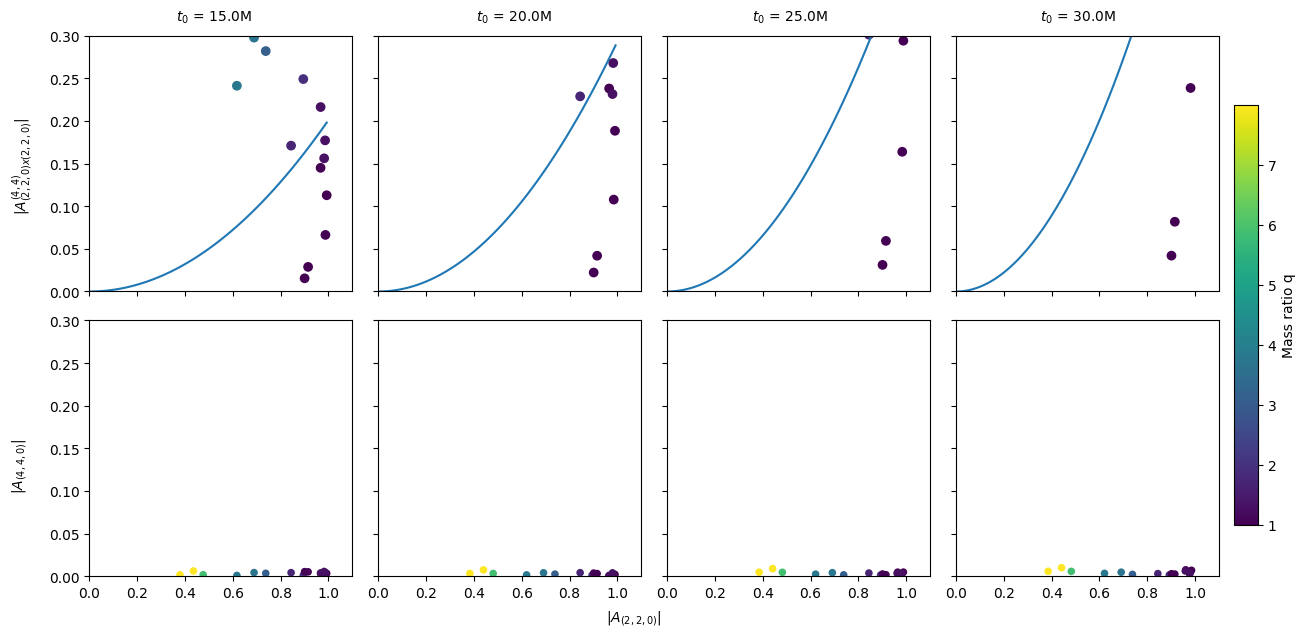

In [13]:
xs = np.linspace(0, np.max(amp_array[0]), 100)

fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)

plot1 = axs[0,0].scatter(amp_array[0][0], amp_array[2][0], c=amp_array[3][0])
axs[0,0].plot(xs, coefs[0]*xs**2)

axs[0,1].scatter(amp_array[0][1], amp_array[2][1], c=amp_array[3][1])
axs[0,1].plot(xs, coefs[1]*xs**2)

axs[0,2].scatter(amp_array[0][2], amp_array[2][2], c=amp_array[3][2])
axs[0,2].plot(xs, coefs[2]*xs**2)

axs[0,3].scatter(amp_array[0][3], amp_array[2][3], c=amp_array[3][3])
axs[0,3].plot(xs, coefs[3]*xs**2)

axs[1,0].scatter(amp_array[0][0], amp_array[1][0], c=amp_array[3][0], s=20)
axs[1,1].scatter(amp_array[0][1], amp_array[1][1], c=amp_array[3][1], s=20)
axs[1,2].scatter(amp_array[0][2], amp_array[1][2], c=amp_array[3][2], s=20)
axs[1,3].scatter(amp_array[0][3], amp_array[1][3], c=amp_array[3][3], s=20)

for ax in axs.flat:
    ax.set_xlim(0, 1)

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  
fig.colorbar(plot1, cax=cbar_ax, label='Mass ratio q')

fig.text(0.5, -0.01, r'$|A_{(2,2,0)}|$', ha='center')
fig.text(0.15, 0.99, f'$t_0$ = {start_times[0]}M', ha='center')
fig.text(0.4, 0.99, f'$t_0$ = {start_times[1]}M', ha='center')
fig.text(0.63, 0.99, f'$t_0$ = {start_times[2]}M', ha='center')
fig.text(0.87, 0.99, f'$t_0$ = {start_times[3]}M', ha='center')
fig.text(-0.02, 0.25, r'$|A_{(4,4,0)}|$', va='center', rotation='vertical')
fig.text(-0.02, 0.75, r'$|A_{(2,2,0)x(2,2,0)}^{(4,4)}|$', va='center', rotation='vertical')

axs[0,0].set_ylim(0,0.3)
axs[0,0].set_xlim(0,1.1)

plt.tight_layout()

# Reproducing Fig. 2

In [29]:
model_l2 = [(l,m,n,1) for n in range(2+1)]
model_q = [(l,m,n,1) for n in range(2+1)] + [quadratic_mode]

model_l2 = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

l2_amp_index = model_l2.index((4,4,0,1))
q_amp_index = model_q.index(quadratic_mode)

In [30]:
sim = CCE_sim305

t0 = 20 

best_fit_l2 = qnmfits.ringdown_fit(
    sim.times,
    sim.h[l,m],
    model_l2,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=t0,
)

best_fit_q = qnmfits.ringdown_fit(
    sim.times,
    sim.h[l,m],
    model_q,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=t0,
)

/data/rvnd2/qnmfitsrd/qnmfitsrd/qnmfits.py:94: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (numerator/denominator)


[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.

ValueError: array of sample points is empty

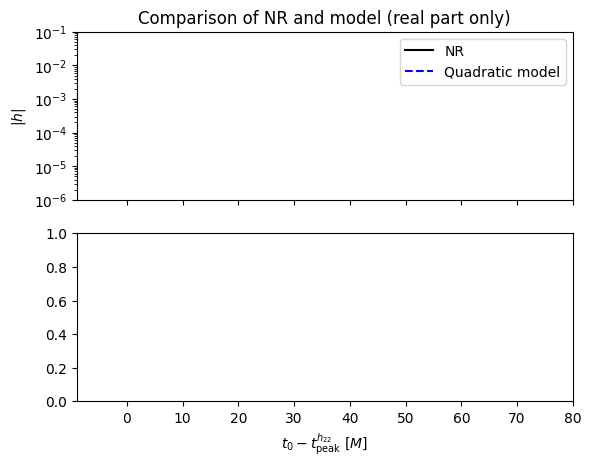

In [34]:
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)

ax[0].set_title('Comparison of NR and model (real part only)')

print(best_fit_l2['C'])

ax[0].plot(sim.times, abs(sim.h[l,m].real), c='black', label = 'NR') 
ax[0].plot(best_fit_q['model_times'], abs(best_fit_q['model'].real), c='b', linestyle='dashed', label = 'Quadratic model')
ax[1].set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax[0].set_ylabel('$|h|$')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlim(-9, 80)
ax[0].set_ylim(1e-6, 1e-1)

interpolated_model_l2 = np.interp(sim.times, best_fit_l2['model_times'], best_fit_l2['model'])
interpolated_model_q = np.interp(sim.times, best_fit_q['model_times'], best_fit_q['model'])

ax[1].set_ylabel('$|h^{NR} - h^{model}|$')
ax[1].plot(sim.times, abs(sim.h[l,m] - interpolated_model_l2), c='r', label = 'Linear model')
ax[1].plot(sim.times, abs(sim.h[l,m] - interpolated_model_q), c='b', linestyle='dashed', label = 'Quadratic model')
ax[1].set_yscale('log')
ax[1].legend()


# Reproducing Fig. 3

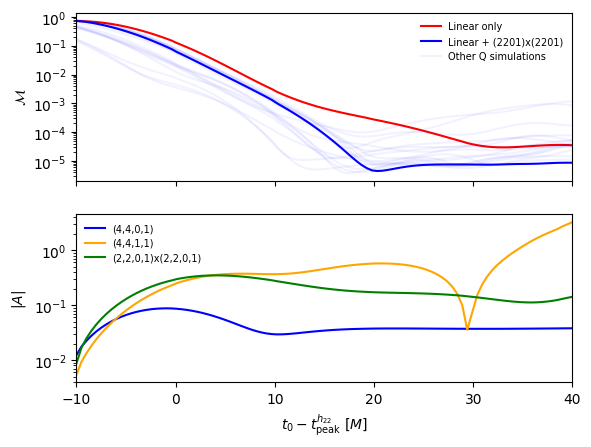

In [40]:
sim = CCE_sim305

l_amp_index_q = model_q.index((l,m,0,1))
l1_amp_index_q = model_q.index((l,m,1,1))
q_amp_index = model_q.index((lp,mp,nprime,pp,lpp,mpp,npp,ppp))

mode_list = [model_l2, model_q]
mode_list_names = ['Linear only', 'Linear + (2201)x(2201)']
mode_colours = ['r', 'b']

# Generate main two lines of plots 

start_times = np.linspace(-10, 40, 100)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

for i, modes in enumerate(mode_list):

    quad_bool = False

    if mode_list_names[i] == 'Linear + (2201)x(2201)':
        quad_bool = True
        amplitudes = []
        amplitudes1 = []
        amplitudesq = []  

    mms = []  

    for j, t0 in enumerate(start_times):

        best_fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[l,m],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0
        )

        mms.append(best_fit['mismatch'])

        if quad_bool:
            amplitudes.append(abs(best_fit['C'][l_amp_index_q]))
            amplitudes1.append(abs(best_fit['C'][l1_amp_index_q]))
            amplitudesq.append(abs(best_fit['C'][q_amp_index]))
    
    ax[0].semilogy(start_times, mms, label=mode_list_names[i], color=mode_colours[i])

    if quad_bool:

        decay_time40 = qnmfits.qnm.omega(l,m,0,1, sim.chif_mag, Mf=sim.Mf).imag
        decay_time41 = qnmfits.qnm.omega(l,m,1,1, sim.chif_mag, Mf=sim.Mf).imag
        decay_time22 = qnmfits.qnm.omega(lp,mp,nprime,pp, sim.chif_mag, Mf=sim.Mf).imag + qnmfits.qnm.omega(lpp,mpp,npp,ppp, sim.chif_mag, Mf=sim.Mf).imag

        ax[1].semilogy(start_times, amplitudes*np.exp(-decay_time40*start_times), label='(4,4,0,1)', c='b') 
        ax[1].semilogy(start_times, amplitudes1*np.exp(-decay_time41*start_times), label='(4,4,1,1)', c='orange')
        ax[1].semilogy(start_times, amplitudesq*np.exp(-decay_time22*start_times), label='(2,2,0,1)x(2,2,0,1)', c='g')

# Generate other simulation plots 

sims = [sim_1502, sim_1476, sim_1506, sim_1508, sim_1474, sim_1505, sim_1504, sim_1485, sim_1486, sim_1441, sim_1500, sim_1492, sim_1465, 
        sim_1458, sim_1438, sim_1430]

for i, sim in enumerate(sims):

    mms = []  

    for j, t0 in enumerate(start_times):

        best_fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[l,m],
            model_q,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0
        )

        mms.append(best_fit['mismatch'])

    if i == len(sims) - 1:
        ax[0].semilogy(start_times, mms, alpha = 0.05, c='b', label='Other Q simulations')
    else:
        ax[0].semilogy(start_times, mms, alpha = 0.05, c='b')

ax[1].set_xlim(start_times[0], start_times[-1])
ax[1].set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax[0].set_ylabel('$\mathcal{M}$')
ax[1].set_ylabel('$|A|$')

_ = ax[0].legend(ncol=1, frameon=False, fontsize=7)
_ = ax[1].legend(ncol=1, frameon=False, fontsize=7)

# Reproduction of Fig. 4

In [177]:
sim = CCE_sim305

t0 = 20

re_min = 0.95
re_max = 1.08
im_min = 0
im_max = 3
step = 100

index = model_q.index((lp,mp,nprime,pp,lpp,mpp,npp,ppp))

In [178]:
im_variation = np.linspace(im_min, im_max, step)
re_variation = np.linspace(re_min, re_max, step)

frequencies = np.array(qnm.omega_list(model_q, sim.chif_mag, sim.Mf))

mm_list = [] 

for v_im in im_variation:
    for v_re in re_variation:

        modified_frequencies = frequencies.copy()
        modified_frequencies[index] = frequencies[index].real * v_re + 1j * frequencies[index].imag * v_im

        best_fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[l,m],
            model_q,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0,
            frequencies = modified_frequencies
        )

        mm_list.append(best_fit['mismatch'])

mm_grid = np.reshape(
    np.array(mm_list), (step, step)
    )

Text(0, 0.5, 'Im($\\omega_{(2,2,0)x(2,2,0)}^{(4,4)}$) offset')

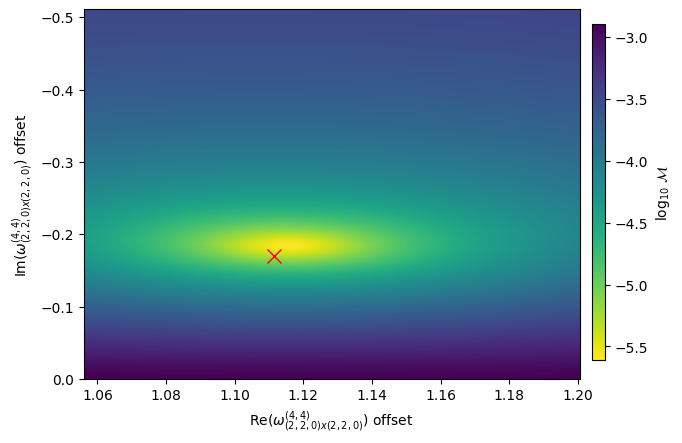

In [194]:
fig, ax = plt.subplots()

xmin = frequencies[index].real*re_min 
xmax = frequencies[index].real*re_max
ymin = frequencies[index].imag*im_min
ymax = frequencies[index].imag*im_max

# Plot heatmap
im = ax.imshow(
    np.log10(mm_grid), 
    extent=[xmin, xmax, ymin, ymax],
    aspect='auto',
    origin='lower',
    interpolation='bicubic',
    cmap='viridis_r')

ax.plot(frequencies[index].real, frequencies[index].imag, color='r', marker='x', markersize=10)

#frequency_442= np.array(qnm.omega_list([(4,4,2,1)], sim.chif_mag, sim.Mf))
#x_offset = frequency_442.real / frequencies.real[index]
#y_offset = frequency_442.imag / frequencies.imag[index]

#ax.plot(x_offset, y_offset, marker='o', markersize=3, color='k')

# Color bar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('$\mathrm{log}_{10}\ \mathcal{M}$')

ax.set_xlabel('Re($\omega_{(2,2,0)x(2,2,0)}^{(4,4)}$) offset')
ax.set_ylabel('Im($\omega_{(2,2,0)x(2,2,0)}^{(4,4)}$) offset')